### Imports and Utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from tueplots import bundles
plt.rcParams.update(bundles.iclr2023())

In [3]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.fully_bayesian import MIN_INFERRED_NOISE_LEVEL
from botorch.models.transforms import Normalize, Standardize
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

In [4]:
# To import from the gauche package
import sys
sys.path.append('..')

from gauche.dataloader.data_utils import transform_data
from gauche.kernels.string_kernels.sskkernel import pad, encode_string, build_one_hot, SubsequenceStringKernel

[03/22/23 01:03:49] WARNING  To use the Graphein submodule                                         ]8;id=755687;file:///dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=393577;file:///dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#43\43]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               

                    WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=454498;file:///dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=804425;file:///dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=144833;file:///dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=594646;file:///dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

In [5]:
# plotting util
def cv_plot(median, q1, q2, y_test):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(
        [torch.min(median), torch.max(median)], 
        [torch.min(median), torch.max(median)], 
        "b--", lw=2
    )
    yerr1, yerr2 = median - q1, q2 - median
    yerr = torch.cat((yerr1.unsqueeze(0), yerr2.unsqueeze(0)), dim=0).squeeze(-1)
    markers, caps, bars = ax.errorbar(
        y_test.squeeze(-1).cpu(),
        median.squeeze(-1).cpu(),
        yerr=yerr.cpu(),
        fmt=".",
        capsize=4,
        elinewidth=2.0,
        ms=14,
        c="k",
        ecolor="gray",
    )
    [bar.set_alpha(0.8) for bar in bars]
    [cap.set_alpha(0.8) for cap in caps]
    ax.set_xlabel("True value", fontsize=20)
    ax.set_ylabel("Predicted value", fontsize=20)
    ax.set_aspect("equal")
    ax.grid(True)
    plt.savefig("ssk.pdf")


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkwargs = {"dtype": torch.float, "device": device}
print(tkwargs)

{'dtype': torch.float32, 'device': device(type='cuda')}


### Data setup

In [7]:
# Regression experiments parameters, number of random splits and split size
n_trials = 20
test_set_size = 0.2

In [8]:
import pandas as pd

df = pd.read_csv('petase_151_mutants.csv')
sequences = df['sequence'].to_list()
targets = df['fitness'].to_numpy().reshape(-1, 1)
print(f'len(sequences) {len(sequences)} | len(targets) {len(targets)}')

len(sequences) 151 | len(targets) 151


In [9]:
maxlen = np.max([len(x) for x in sequences])
# get alphabet of characters used in candidate set (to init SSK)
alphabet = list({l for word in sequences for l in word})
print(f'alphabet \n {alphabet} \n length of alphabet {len(alphabet)}')
print(f'maxlen {maxlen}')

alphabet 
 ['K', 'D', 'M', 'P', 'Y', 'V', 'T', 'F', 'S', 'L', 'C', 'G', 'R', 'Q', 'W', 'A', 'I', 'H', 'E', 'N'] 
 length of alphabet 20
maxlen 290


### Model Fits and Prediction

In [10]:
def get_gp_model(X, Y):
    likelihood = GaussianLikelihood(
        noise_prior=GammaPrior(torch.tensor(0.9, **tkwargs), torch.tensor(10.0, **tkwargs)),
        noise_constraint=GreaterThan(MIN_INFERRED_NOISE_LEVEL),
    )
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        SubsequenceStringKernel(embds, index, alphabet, maxlen, **tkwargs),
    )
    gp_model = SingleTaskGP(
        train_X=X,
        train_Y=Y,
        outcome_transform=Standardize(1),
        likelihood=likelihood,
        covar_module=covar_module,
    )
    mll = ExactMarginalLogLikelihood(model=gp_model, likelihood=gp_model.likelihood)
    # ideally we can optimize over the kernel hyper-parameters of the string kernel
    # however, the gpu memory usage in batch (GPU) version of the kernel is quite high
    # while the standard non-batch version is relatively slow for kernel evaluation.
    # Nevertheless, the kernel is very robust to choices of different these hyper-params.
    mll.model.covar_module.base_kernel.raw_order_coefs.requires_grad = False
    mll.model.covar_module.base_kernel.raw_match_decay.requires_grad = False
    mll.model.covar_module.base_kernel.raw_gap_decay.requires_grad = False
    return mll, gp_model

In [11]:
embds, index = build_one_hot(alphabet)
embds = embds.to(**tkwargs)
all_encoded_sequences = torch.cat(
    [pad(encode_string(x, index), maxlen).unsqueeze(0) for x in sequences],
    dim=0
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    all_encoded_sequences, 
    targets, 
    test_size=test_set_size, 
    random_state=0
)
X_train = X_train.to(**tkwargs)
X_test = X_test.to(**tkwargs)
y_train = torch.tensor(y_train, **tkwargs)
y_test = torch.tensor(y_test, **tkwargs)

In [13]:
mll, gp_model = get_gp_model(X_train, y_train)
fit_gpytorch_model(mll)

/dfs/user/sttruong/env/geometric_ampere/lib/python3.8/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-06)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): SubsequenceStringKernel(
        (raw_gap_decay_constraint): Interval(0.000E+00, 1.000E+00)
        (raw_match_decay_constraint): Interval(0.000E+00, 1.000E+00)
        (raw_order_coefs_constraint): Interval(0.000E+00, 1.000E+00)
      )
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

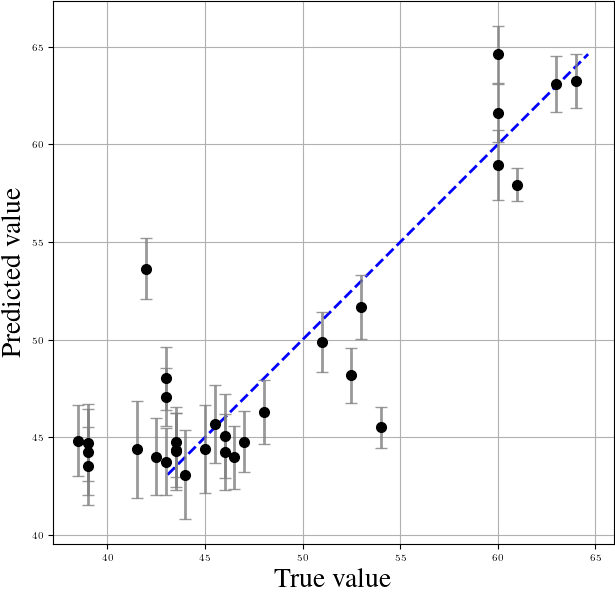

In [14]:
posterior = gp_model.posterior(X_test)
median = posterior.mean.cpu().detach()
std = posterior.variance.cpu().detach()**(1/2)
q1 = median - std
q2 = median + std
cv_plot(median, q1, q2, y_test)

In [18]:
print("R2_score: ", r2_score(median.squeeze(1), y_test.cpu().detach().squeeze(1)))
print("MAE: ", mean_absolute_error(median.squeeze(1), y_test.cpu().detach().squeeze(1)))

R2_score:  0.6735538594252475
MAE:  2.8363397


### Testing BoTorch compatibility

In [16]:
from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

In [17]:
qmc_sampler = SobolQMCNormalSampler(sample_shape=32)
qEI = qExpectedImprovement(
    model=gp_model, best_f=y_train.max(),
    sampler=qmc_sampler)
print(qEI(X_test.unsqueeze(1)))

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0023], device='cuda:0',
       grad_fn=<MeanBackward1>)
